In [ ]:
# hide
# skip
!git clone https://github.com/benihime91/gale # install gale on colab
!pip install -e "gale[dev]"

In [ ]:
# default_exp classification.task

In [ ]:
# hide
%load_ext nb_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

<IPython.core.display.Javascript object>

In [ ]:
# hide
import warnings

from nbdev.export import *
from nbdev.showdoc import *
from timm.utils import *

warnings.filterwarnings("ignore")

setup_default_logging()

<IPython.core.display.Javascript object>

# Classification Task
> Lightning Image Classification Task

In [ ]:
# export
import functools
import logging
from typing import *

import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torchmetrics
from fastcore.all import *
from omegaconf import DictConfig, ListConfig, OmegaConf
from pytorch_lightning.trainer.states import RunningStage
from timm.data.mixup import Mixup, mixup_target
from torch import nn

from gale.classification.augment import *
from gale.classification.core import *
from gale.classification.data import *
from gale.classification.model import build_model
from gale.core_classes import BasicModule, DefaultTask
from gale.losses import build_loss
from gale.torch_utils import trainable_params
from gale.utils.display import *

_logger = logging.getLogger(__name__)

<IPython.core.display.Javascript object>

In [ ]:
# export
# hide
# fmt: off
class Mixup(Mixup):
    """
    CPU friendly Mixup from timm
    """
    def __call__(self, x, target):
        assert len(x) % 2 == 0, 'Batch size should be even when using this'
        if self.mode == 'elem':
            lam = self._mix_elem(x)
        elif self.mode == 'pair':
            lam = self._mix_pair(x)
        else:
            lam = self._mix_batch(x)
        target = mixup_target(target, self.num_classes, lam, self.label_smoothing, device=x.device)
        return x, target
# fmt: on

<IPython.core.display.Javascript object>

In [ ]:
# export
def predict_context(func: Callable) -> Callable:
    """
    This decorator is used as context manager
    to put model in eval mode before running predict and reset to train after.
    """

    @functools.wraps(func)
    def wrapper(self, *args, **kwargs) -> Any:
        grad_enabled = torch.is_grad_enabled()
        is_training = self.training
        self.eval()
        torch.set_grad_enabled(False)

        result = func(self, *args, **kwargs)

        if is_training:
            self.train()
        torch.set_grad_enabled(grad_enabled)
        return result

    return wrapper

<IPython.core.display.Javascript object>

In [ ]:
# export
class ClassificationTask(DefaultTask):
    is_restored = True
    """
    A General PyTorch Lightning Task for Image Classification

    Arguments:
    1. cfg: gale default config.
    2. trainer (Optional): Pytorch Lightning Trainer instance
    2. metrics (Optional): A List of `torchmetrics` used during training.
    """

    def __init__(
        self,
        cfg: DictConfig,
        trainer: pl.Trainer = None,
        metrics: Union[torchmetrics.Metric, Mapping, Sequence, None] = None,
    ):
        super(ClassificationTask, self).__init__(
            cfg=cfg, trainer=trainer, metrics=metrics
        )
        # Train Loss is used for the Training Dataset
        self.train_loss = noop
        # Eval Loss is used for Validation / Test Datasets
        self.eval_loss = noop
        self.setup()

    def setup(self, stage: Optional[str] = None):
        """
        Sets up the model and all the modelitites of the `pl.LightningModule`.
        This is called during task initialization.
        """
        # that means model has not been build manually
        # so we need to build it
        if self._model is noop:
            self.setup_model()

        # if the trainer is passed, that means we are in training
        # so we need to setup the train_dataloaders, valid_dataloaders (Optional)
        # test_dataloaders (Optional) and the optimziation for ht emodel
        if not self.is_restored:
            if self._train_dl is noop:
                self.setup_training_data()
            if self._validation_dl is noop:
                self.setup_validation_data()
            if self._test_dl is noop:
                self.setup_test_data()
            if self._optimizer is noop and self._scheduler is noop:
                optim = self.process_optim_config(self._cfg.optimization)
                self.setup_optimization(optim)

            # setup mixup/cutmix for the model
            mixup_args = self._cfg.training.mixup.init_args
            self.mixup_off_epoch = self._cfg.training.mixup.off_epoch
            self.mixup_fn = Mixup(**mixup_args)

            # build up the loss functions
            self.train_loss = build_loss(self._cfg.training.train_loss_fn)
            self.eval_loss = build_loss(self._cfg.training.eval_loss_fn)

            shapes = (
                self._cfg.input.channels,
                self._cfg.input.height,
                self._cfg.input.width,
            )
            self.example_input_array = torch.randn(1, *shapes)

            if self._cfg.input.mean == "imagenet":
                mean, std = imagenet_stats
            elif self._cfg.input.mean == "cifar":
                mean, std = cifar_stats
            elif self._cfg.input.mean == "mnist":
                mean, std = mnist_stats
            else:
                mean, std = np.array(self._cfg.input.mean), np.array(
                    self._cfg.input.std
                )

            self.mean = torch.tensor(np.array(mean)).float()
            self.std = torch.tensor(np.array(std)).float()

    def forward(self, x):
        """
        Forward method: we pass in the input through the meta_arch
        to get the predictions for the current image batch
        """
        return self._model(x)

    def shared_step(self, batch: Any, batch_idx: int, stage: str) -> Dict:
        """
        Common steps for training, validation and test stages. Shared step
        returns a dictionary containing the `loss` and `logs`, which are the metric
        values computed at `stage`. This also applies `mixup/cutmix` to the training data
        if specified in config.
        """
        stages = ["train", "validation", "test"]
        assert stage in stages

        # Check wether Mixup Threshold is reached and stop mixup
        # makes no sense to check in other stages; so check in
        # the training stage
        if stage == "train":
            if self.mixup_off_epoch and self.current_epoch >= self.mixup_off_epoch:
                self.mixup_fn.mixup_enabled = False

        # Unpack Batch
        x, y = batch

        # Apply mixup in the training stage
        if stage == "train":
            # NOTE: This converts the targets into 1 hot vectores
            x, y_mix = self.mixup_fn(x, y)

        # calculate the logits
        y_hat = self(x)

        # Comput Loss
        if stage == "train":
            loss = self.train_loss(y_hat, y_mix)
        else:
            loss = self.eval_loss(y_hat, y)

        # compute probas
        y_hat = F.softmax(y_hat)

        logs = {}
        logs["loss"] = loss

        for name, metric in self.metrics.items():
            if isinstance(metric, torchmetrics.metric.Metric):
                metric(y_hat, y)
                logs[name] = metric
            else:
                logs[name] = metric(y_hat, y)

        output = dict(loss=loss, logs=logs)
        return output

    def setup_model(self, args: DictConfig = None):
        """
        Builds up the meta architecture. You can also additionally pass in args to configure
        from a config other than the orignal one.
        """
        conf = ifnone(args, self._cfg)
        meta_arch = build_model(conf)
        self._model = meta_arch

    @property
    def param_dicts(self):
        """Returns the paramters for model optimization"""
        return (
            self._model.build_param_dicts()
            if self._model is not noop
            else trainable_params(self)
        )

    def setup_training_data(self, name: str = None, dls_conf: DictConfig = None):
        """
        Builds the training dataset from name and the dataloader from `dls_conf`, if
        None then parsers the values from the passed config while creating the instance
        """
        name = ifnone(name, self._cfg.datasets.train)
        conf = ifnone(dls_conf, self._cfg.dataloader.train)
        self._train_dl = build_classification_loader_from_config(name, conf)

    def setup_validation_data(
        self, name: Union[List, str] = None, dls_conf: DictConfig = None
    ):
        """Same as `setup_training_data` but sets up validation dataset and dataloaders"""
        name = ifnone(name, self._cfg.datasets.valid)
        conf = ifnone(dls_conf, self._cfg.dataloader.valid)

        # if name is still none , that means no validation data
        if name is None:
            self._validation_dl = None
        else:
            if isinstance(name, list) or isinstance(name, ListConfig):
                names = list(name)
                dls = [build_classification_loader_from_config(n, conf) for n in names]
            elif isinstance(name, str):
                dls = build_classification_loader_from_config(name, conf)
            else:
                _logger.warning(
                    "Validation dataset name format not understood. Must either be str or List."
                )
                dls = None
            self._validation_dl = dls

    def setup_test_data(
        self, name: Union[List, str] = None, dls_conf: DictConfig = None
    ):
        """Same as `setup_training_data` but sets up test dataset and dataloaders"""
        name = ifnone(name, self._cfg.datasets.test)
        conf = ifnone(dls_conf, self._cfg.dataloader.test)

        # if name is still none , that means no validation data
        if name is None:
            self._test_dl = None
        else:
            if isinstance(name, list) or isinstance(name, ListConfig):
                names = list(name)
                dls = [build_classification_loader_from_config(n, conf) for n in names]
            elif isinstance(name, str):
                dls = build_classification_loader_from_config(name, conf)
            else:
                _logger.warning(
                    "Test dataset name format not understood. Must either be str or List"
                )
                dls = None
            self._test_dl = dls

    def test_dataloader(self):
        self.setup_test_data()
        if self._test_dl is None or self._test_dl is noop:
            return None
        else:
            return self._test_dl

    @property
    def model(self):
        return self._model

    @model.setter
    def model(self, m: BasicModule):
        assert isinstance(m, BasicModule)
        self._model = m

    def predict_step(self, batch: Any, batch_idx: int, dataloader_idx: int = 0) -> Any:
        if isinstance(batch, tuple):
            batch = batch[0]
        return self(batch)

    @predict_context
    def generate_preds(self, batch: Tuple) -> Tuple[L, L, L]:
        """
        Generate predictions for batch. Returns the Images, Targets & Predictions for the
        Batch.
        """
        running_stage = RunningStage.PREDICTING
        x = self.transfer_batch_to_device(batch, self.device)
        x, y = batch

        preds = self.predict_step(x, 0)
        _, preds = torch.max(preds, 1)

        x = denormalize(x, self.mean, self.std)

        ims = L(i for i in x.data.cpu())
        targs = L(t for t in y.data.cpu().numpy())
        preds = L(p for p in preds.data.cpu().numpy())
        return ims, targs, preds

<IPython.core.display.Javascript object>

### Internals

In [ ]:
show_doc(ClassificationTask.setup)

<h4 id="ClassificationTask.setup" class="doc_header"><code>ClassificationTask.setup</code><a href="__main__.py#L28" class="source_link" style="float:right">[source]</a></h4>

> <code>ClassificationTask.setup</code>(**`stage`**:`Optional`\[`str`\]=*`None`*)

Sets up the model and all the modelitites of the `pl.LightningModule`.
This is called during task initialization.

<IPython.core.display.Javascript object>

In [ ]:
show_doc(ClassificationTask.forward)

<h4 id="ClassificationTask.forward" class="doc_header"><code>ClassificationTask.forward</code><a href="__main__.py#L82" class="source_link" style="float:right">[source]</a></h4>

> <code>ClassificationTask.forward</code>(**`x`**)

Forward method: we pass in the input through the meta_arch
to get the predictions for the current image batch

<IPython.core.display.Javascript object>

In [ ]:
show_doc(ClassificationTask.shared_step)

<h4 id="ClassificationTask.shared_step" class="doc_header"><code>ClassificationTask.shared_step</code><a href="__main__.py#L89" class="source_link" style="float:right">[source]</a></h4>

> <code>ClassificationTask.shared_step</code>(**`batch`**:`Any`, **`batch_idx`**:`int`, **`stage`**:`str`)

Common steps for training, validation and test stages. Shared step
returns a dictionary containing the `loss` and `logs`, which are the metric
values computed at `stage`. This also applies `mixup/cutmix` to the training data
if specified in config.

<IPython.core.display.Javascript object>

In [ ]:
show_doc(ClassificationTask.generate_preds)

<h4 id="ClassificationTask.generate_preds" class="doc_header"><code>ClassificationTask.generate_preds</code><a href="__main__.py#L233" class="source_link" style="float:right">[source]</a></h4>

> <code>ClassificationTask.generate_preds</code>(**`batch`**:`Tuple`)

Generate predictions for batch. Returns the Images, Targets & Predictions for the
Batch.

<IPython.core.display.Javascript object>

### Overrides

In [ ]:
show_doc(ClassificationTask.setup_training_data)

<h4 id="ClassificationTask.setup_training_data" class="doc_header"><code>ClassificationTask.setup_training_data</code><a href="__main__.py#L157" class="source_link" style="float:right">[source]</a></h4>

> <code>ClassificationTask.setup_training_data</code>(**`name`**:`str`=*`None`*, **`dls_conf`**:`DictConfig`=*`None`*)

Builds the training dataset from name and the dataloader from `dls_conf`, if
None then parsers the values from the passed config while creating the instance

<IPython.core.display.Javascript object>

In [ ]:
show_doc(ClassificationTask.setup_validation_data)

<h4 id="ClassificationTask.setup_validation_data" class="doc_header"><code>ClassificationTask.setup_validation_data</code><a href="__main__.py#L166" class="source_link" style="float:right">[source]</a></h4>

> <code>ClassificationTask.setup_validation_data</code>(**`name`**:`Union`\[`List`, `str`\]=*`None`*, **`dls_conf`**:`DictConfig`=*`None`*)

Same as `setup_training_data` but sets up validation dataset and dataloaders

<IPython.core.display.Javascript object>

In [ ]:
show_doc(ClassificationTask.setup_test_data)

<h4 id="ClassificationTask.setup_test_data" class="doc_header"><code>ClassificationTask.setup_test_data</code><a href="__main__.py#L189" class="source_link" style="float:right">[source]</a></h4>

> <code>ClassificationTask.setup_test_data</code>(**`name`**:`Union`\[`List`, `str`\]=*`None`*, **`dls_conf`**:`DictConfig`=*`None`*)

Same as `setup_training_data` but sets up test dataset and dataloaders

<IPython.core.display.Javascript object>

In [ ]:
show_doc(ClassificationTask.setup_optimization)

<h4 id="DefaultTask.setup_optimization" class="doc_header"><code>DefaultTask.setup_optimization</code><a href="https://github.com/benihime91/gale/tree/master/gale/core_classes.py#L382" class="source_link" style="float:right">[source]</a></h4>

> <code>DefaultTask.setup_optimization</code>(**`conf`**:`DictConfig`=*`None`*)

Prepares an optimizer from a string name and its optional config parameters.
You can also manually call this method with a valid optimization config
to setup the optimizers and lr_schedulers.

<IPython.core.display.Javascript object>

### Helpers

In [ ]:
# export
@delegates(subplots)
def get_grid(
    n,
    nrows=None,
    ncols=None,
    add_vert=0,
    figsize=None,
    double=False,
    title=None,
    return_fig=False,
    flatten=True,
    **kwargs
):
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows:
        ncols = ncols or int(np.ceil(n / nrows))
    elif ncols:
        nrows = nrows or int(np.ceil(n / ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    if double:
        ncols *= 2
        n *= 2
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    if flatten:
        axs = [
            ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())
        ][:n]
    if title is not None:
        fig.suptitle(title, weight="bold", size=14)
    return (fig, axs) if return_fig else axs

<IPython.core.display.Javascript object>

By default, there will be `int(math.sqrt(n))` rows and `ceil(n/rows)` columns. double will double the number of columns and n. The default figsize is `(cols*imsize, rows*imsize+add_vert)`. If a title is passed it is set to the figure. sharex, sharey, squeeze, subplot_kw and gridspec_kw are all passed down to plt.subplots. If return_fig is True, returns fig,axs, otherwise just axs. flatten will flatten the matplot axes such that they can be iterated over with a single loop.

In [ ]:
# export
@patch
def show_results(
    self: ClassificationTask,
    dataloader: torch.utils.data.DataLoader = None,
    ctxs=None,
    max_n: int = 10,
    nrows: int = None,
    ncols: int = None,
    figsize: Tuple = None,
    **kwargs,
):
    """
    Displays the results for `max_n` items of a batch in `Dataloader` if given or else
    uses test or validationd dataloader
    """

    dls = ifnone(self._test_dl, self._validation_dl)

    dls = ifnone(dataloader, dls)

    if dls is None:
        _logger.warning("No Dataloader, skipping show_results")
        return

    batch = next(iter(dls))
    batch = batch[:max_n]

    samples, targs, preds = self.generate_preds(batch)

    if ctxs is None:
        ctxs = get_grid(
            min(len(samples), max_n),
            nrows=nrows,
            ncols=ncols,
            add_vert=1,
            figsize=figsize,
        )

    ctxs = [
        show_image(s, ctx=c, **kwargs) for s, c, _ in zip(samples, ctxs, range(max_n))
    ]
    ctxs = [
        show_title(f"actual: {t}", ctx=c, **kwargs)
        for t, c, _ in zip(targs, ctxs, range(max_n))
    ]
    ctxs = [
        show_title(
            f"predicted: {p}", ctx=c, color="green" if p == t else "red", **kwargs
        )
        for p, t, c, _ in zip(preds, targs, ctxs, range(max_n))
    ]
    return ctxs

<IPython.core.display.Javascript object>

In [ ]:
# export
@patch_to(ClassificationTask)
@use_kwargs_dict(keep=True, n=8, nrows=2, ncols=4, figsize=None, imsize=3)
def show_batch(self: ClassificationTask, prefix: str = "train", **kwargs):
    """Displays a batch from a dataloader defined by prefix"""
    if self._train_dl is noop:
        self.setup()

    if prefix == "train":
        loader = [self._train_dl]

    elif prefix == "validation":
        loader = self._validation_dl

    elif prefix == "test":
        loader = self._test_dl
    else:
        raise ValueError("Unkonwn stage must be train, validation or test")

    if loader is None:
        _logger.warning(f"No Dataset and DataLoader provied for {prefix} stage")
        _logger.info("Skipping show batch")
        return
    else:
        # DataLoaders can either be List or DataLoader
        try:
            loader = loader[0]
        except:
            pass

    inputs, classes = next(iter(loader))

    if prefix == "train":
        inputs, _ = self.mixup_fn(inputs, classes)

    batch = (inputs, classes)
    show_image_batch(batch, mean=self.mean, std=self.std, **kwargs)

<IPython.core.display.Javascript object>

## Minimal Example

Now let's look at how we can train an image classifier using `ClassificationTask`.

In [ ]:
from fastcore.all import Path
from nbdev.export import Config

from gale.classification.augment import *
from gale.classification.data import register_dataset_from_folders
from gale.collections.callbacks.notebook import NotebookProgressCallback
from gale.collections.download import download_and_extract_archive
from gale.config import get_config

<IPython.core.display.Javascript object>

*Let's take this [tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#training-the-model) and see how we can achieve this in PyTorch Gale ...*

### Prepare the dataset

The dataset can be downloaded and decompressed with this line of code:

In [ ]:
URL = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
data_path = Path(Config().path("nbs_path")) / "data"

# download a toy dataset
download_and_extract_archive(url=URL, download_root=data_path, extract_root=data_path)

data_path = data_path / "hymenoptera_data"
data_path.ls()

Using downloaded and verified file: /Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data.zip
Extracting /Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data.zip to /Users/ayushman/Desktop/gale/nbs/data


(#2) [Path('/Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data/train'),Path('/Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data/val')]

<IPython.core.display.Javascript object>

We first need to setup up our datasets. Our Images are stored in `train` and `val` folders respectively. We register these datasets into the `DatasetCatalog` -

In [ ]:
# train data is present in :
train_data = data_path / "train"
val_data = data_path / "val"

train_data.ls()
val_data.ls()

(#2) [Path('/Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data/val/bees'),Path('/Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data/val/ants')]

<IPython.core.display.Javascript object>

We take the convenience function `register_dataset_from_folders` which parses the images, creates the labels and registers it into `DatasetCatalog`

In [ ]:
image_roots = L(train_data, val_data)
augments = L(imagenet_augment_transform(224), imagenet_no_augment_transform(224))

for i, a, d in zip(image_roots, augments, ["train", "val"]):
    register_dataset_from_folders("hymenoptera_" + d, i, augmentations=a)

Dataset: hymenoptera_train registerd to DatasetCatalog
Dataset: hymenoptera_val registerd to DatasetCatalog


<IPython.core.display.Javascript object>

### Train!

Now, let's fine-tune a imagenet-pretrained `ResNet18` model and finetune it on the `hymenoptera` dataset.

In [ ]:
# Create or Update the Gale default Config :

# we can also specify overrides using the api of HYDRA
overrides = [
    "head@model.head=classification/fc_head",  # this modifies the head of the model
    "optimizer=adamw",  # this modifies the optimizer
    "scheduler=onecycle",  # this modifies the scheduler in the optimizer
]

cfg = get_config("classification", overrides=overrides)

<IPython.core.display.Javascript object>

In [ ]:
# input arguments :
cfg.input.channels = 3
cfg.input.height = 224
cfg.input.width = 224

# model arguments :
cfg.model.num_classes = 2  # has two class (ants, bees).
# NOTE: this config means the number of classes

cfg.model.backbone.init_args.model_name = "resnet18"
cfg.model.backbone.init_args.pretrained = True
cfg.model.backbone.init_args.freeze_at = 4
cfg.model.backbone.init_args.lr = 1e-06  # pick a good LR for the backbone
cfg.model.backbone.init_args.wd = 0.0

cfg.model.head.init_args.num_classes = "${model.num_classes}"
cfg.model.head.init_args.lr = 1e-02  # pick a good LR for the classifier
cfg.model.head.init_args.filter_wd = False
cfg.model.head.init_args.drop_rate = 0.3
cfg.model.head.init_args.wd = 0.0

# datasets :
cfg.datasets.train = "hymenoptera_train"
cfg.datasets.valid = "hymenoptera_val"
cfg.datasets.test = "hymenoptera_val"

<IPython.core.display.Javascript object>

In [ ]:
# print config
# print(OmegaConf.to_yaml(cfg))

<IPython.core.display.Javascript object>

In [ ]:
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

# specify your model training callbacks
cbs = [
    NotebookProgressCallback(),
    LearningRateMonitor(cfg.optimization.scheduler.interval, log_momentum=True),
]

# Initialize the pytorch-lightning trainer with all its goodies
trainer = pl.Trainer(max_epochs=4, callbacks=cbs, log_every_n_steps=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


<IPython.core.display.Javascript object>

In [ ]:
# Initialize out LightningModule
task = ClassificationTask(cfg, trainer, metrics=torchmetrics.Accuracy())

Building GeneralizedImageClassifier from config ...
Loading pretrained weights from url (https://download.pytorch.org/models/resnet18-5c106cde.pth)
Model created, param count: 11.2 M.


<IPython.core.display.Javascript object>

In [ ]:
# # hide
# print(task)

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:

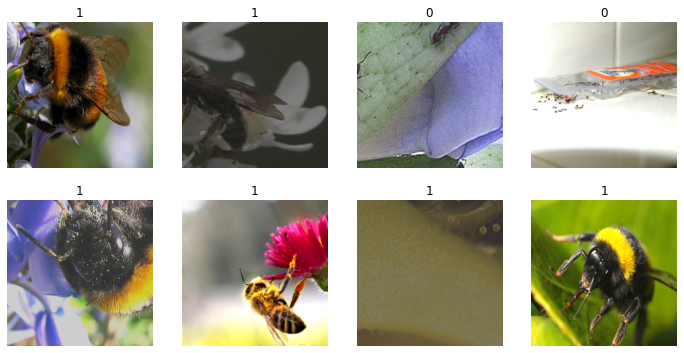

<IPython.core.display.Javascript object>

In [ ]:
# slow
task.show_batch("train", n=8)

In [ ]:
# slow
# Train the model ⚡
trainer.fit(task)


  | Name       | Type                       | Params | In sizes         | Out sizes
-----------------------------------------------------------------------------------------
0 | _metrics   | ModuleDict                 | 0      | ?                | ?        
1 | _model     | GeneralizedImageClassifier | 11.2 M | [1, 3, 224, 224] | [1, 2]   
2 | train_loss | SoftTargetCrossEntropy     | 0      | ?                | ?        
3 | eval_loss  | CrossEntropyLoss           | 0      | ?                | ?        
-----------------------------------------------------------------------------------------
8.4 M     Trainable params
2.8 M     Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


epoch,val/loss,val/accuracy,train/loss,train/accuracy,time,samples/s
0,0.323344,0.875817,0.515968,0.800000,32.280200,0.402700
1,0.182327,0.941176,0.245177,0.900000,32.835700,0.395900
2,0.182145,0.947712,0.355949,0.850000,31.498000,0.412700
3,0.204220,0.921569,0.297929,0.850000,30.248500,0.429800


1

<IPython.core.display.Javascript object>

### Inference & evaluation using the trained model

Now, let's run inference with the trained model on the test which in our case is same as the validation dataset

In [ ]:
# slow
# Evalute the Model:
trainer.test(ckpt_path="best")

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': 0.9215686321258545, 'test/loss': 0.20422008633613586}
--------------------------------------------------------------------------------


[{'test/loss': 0.20422008633613586, 'test/accuracy': 0.9215686321258545}]

<IPython.core.display.Javascript object>

Visualize the prediction results on the test dataset

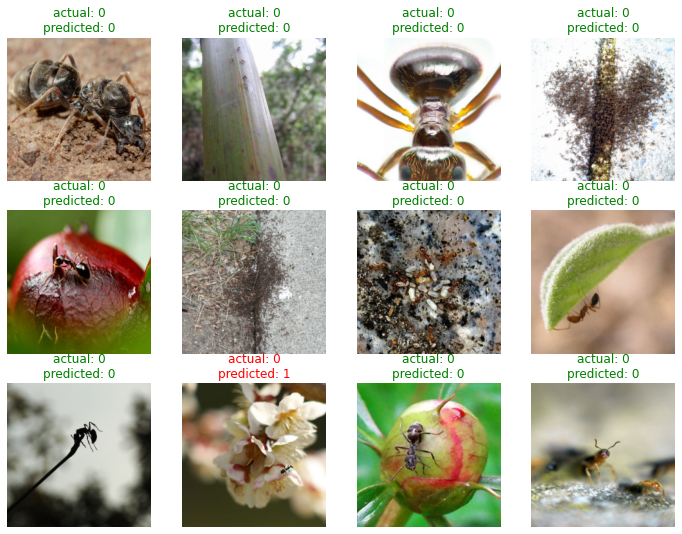

<IPython.core.display.Javascript object>

In [ ]:
# slow
_ = task.show_results(max_n=12)

In Colab, you can use the TensorBoard magic function to view the logs that Lightning has created for you!

In [ ]:
# slow
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

## Export-

In [ ]:
# hide
from nbdev.export import notebook2script

notebook2script("06_classification.task.ipynb")

Converted 06_classification.task.ipynb.


<IPython.core.display.Javascript object>